In [1]:
%load_ext watermark


In [2]:
from colorclade import draw_colorclade_tree
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from pylib._build_hstrat_surfaces import build_hstrat_surfaces
from pylib._build_path import build_path
from pylib._make_seed_coordinates import make_seed_coordinates
from pylib._pathsplot import pathsplot
from pylib.auxlib._hstrat_reconstruct_dataframe import (
    hstrat_reconstruct_dataframe,
)
from pylib.auxlib._log_context_duration import log_context_duration
from pylib.auxlib._make_hstrat_surface_dataframe import (
    make_hstrat_surface_dataframe,
)
from pylib.auxlib._make_reproducible import make_reproducible
from pylib.auxlib._shift_no_wrap import shift_no_wrap
from pylib.auxlib._transform_box_max import TransformBoxMax
from pylib.synthgeom._AttributeBoxMax import AttributeBoxMax
from pylib.synthgeom._VideoWriter import VideoWriter
from pylib.synthgeom._generate_observations import generate_observations

make_reproducible()


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-24T18:54:39.819127+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib: 3.9.2
numpy     : 1.23.5

Watermark: 2.4.3



In [4]:
SX, SY = 400, 400
crea_func = np.ones
crea_size = 10
num_frames = 1000
dstream_algo = "dstream.tilted_algo"
dstream_S = 64


def mirror_backtrack_transform(arr, i):
    return shift_no_wrap(arr, (min(i, SX // 4), -min(i, SY // 4)), axis=(0, 1))


In [5]:
def show_sample_observations(
    SX,
    SY,
    *,
    crea_func,
    crea_size=crea_size,
    every_nth=5,
    fps=30.0,
    logger=print,
    mirror_backtrack=False,
    mirror_backtrack_transform=mirror_backtrack_transform,
    num_frames=1000,
):

    observations = generate_observations(
        SX=SX,
        SY=SY,
        crea_func=crea_func,
        crea_size=crea_size,
        mirror_backtrack=mirror_backtrack,
        mirror_backtrack_transform=mirror_backtrack_transform,
        num_frames=num_frames,
    )
    with log_context_duration("Creating video", logger=logger):
        with VideoWriter("out.gif", fps) as vid:
            vid.add_observations(observations, every_nth=every_nth)
            vid.show()

    with log_context_duration("Creating reversed video", logger=logger):
        with VideoWriter("out.gif", fps) as vid:
            vid.add_observations(
                observations, every_nth=every_nth, reorder=reversed
            )
            vid.show()

    return observations


In [6]:
def show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    *,
    dstream_algo,
    dstream_S,
    num_frames,
):
    surfaces = build_hstrat_surfaces(
        obvs,
        (SY, SX),
        TransformBoxMax(10),
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
    )
    surfaces_df = make_hstrat_surface_dataframe(
        surfaces[-1],
        num_frames + dstream_S,
        values=obvs[-1],
        dstream_algo=dstream_algo,
    )
    surfaces_phylo = hstrat_reconstruct_dataframe(
        surfaces_df[surfaces_df["value"] > 0.2],
    )
    surfaces_phylo["ancestor_list"] = [
        "[]" if id_ == ancestor_id else f"[{ancestor_id}]"
        for (id_, ancestor_id) in zip(
            surfaces_phylo["id"],
            surfaces_phylo["ancestor_id"],
        )
    ]
    draw_colorclade_tree(
        surfaces_phylo,
        taxon_name_key="id",
        backend="biopython",
    )
    plt.show()


In [7]:
seed_coordinates = make_seed_coordinates(
    x_coords=range(SX // 8, SX, SX // 4),
    y_coords=range(SY // 8, SY, SY // 4),
)


## `crea_func=np.ones` `mirror_backtrack=False`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


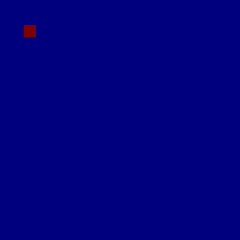

exit log_context_duration for Creating video
!!! {"Creating video": 4.525405168533325}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


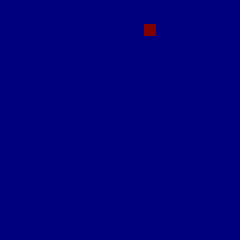

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 3.933288812637329}


100%|██████████| 16/16 [00:01<00:00, 13.82it/s]


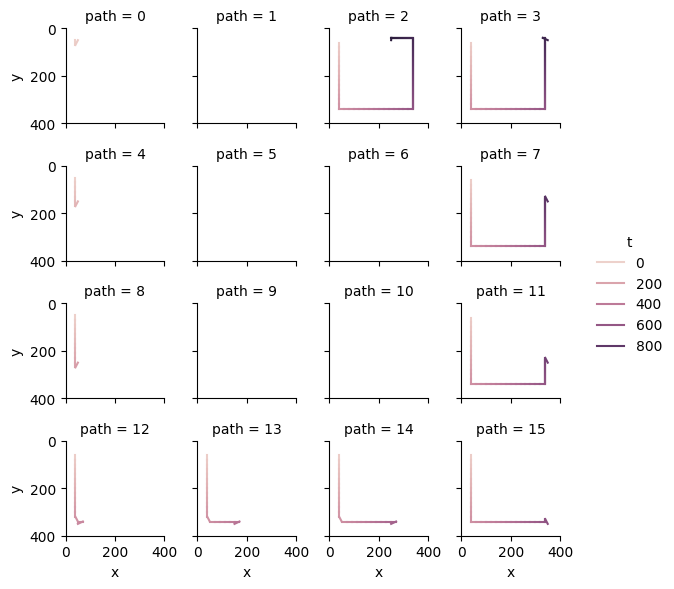

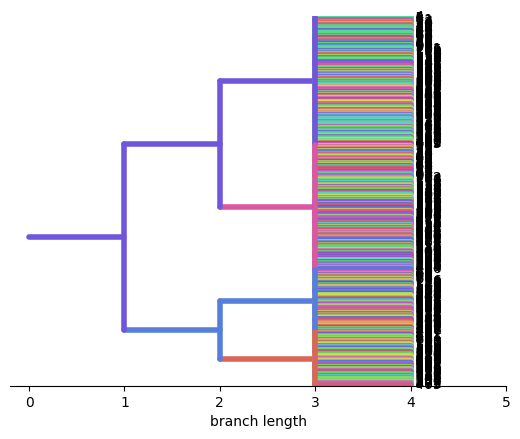

In [8]:
obvs = show_sample_observations(
    SX,
    SY,
    crea_func=np.ones,
    mirror_backtrack=False,
    num_frames=num_frames,
)
observations = pathsplot(
    [
        build_path(coordinate, obvs, AttributeBoxMax(20))
        for coordinate in tqdm(seed_coordinates)
    ],
    xmax=SX,
    ymax=SY,
    col_wrap=4,
)
plt.show()

show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    dstream_algo=dstream_algo,
    dstream_S=dstream_S,
    num_frames=num_frames,
)


## `crea_func=np.ones` `mirror_backtrack=True`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


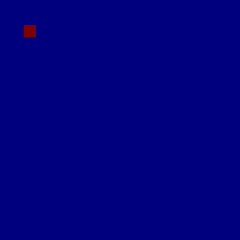

exit log_context_duration for Creating video
!!! {"Creating video": 4.129742622375488}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


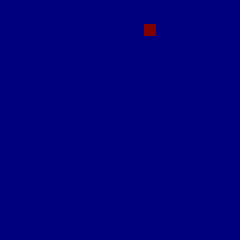

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.139475584030151}


100%|██████████| 16/16 [00:01<00:00, 11.13it/s]


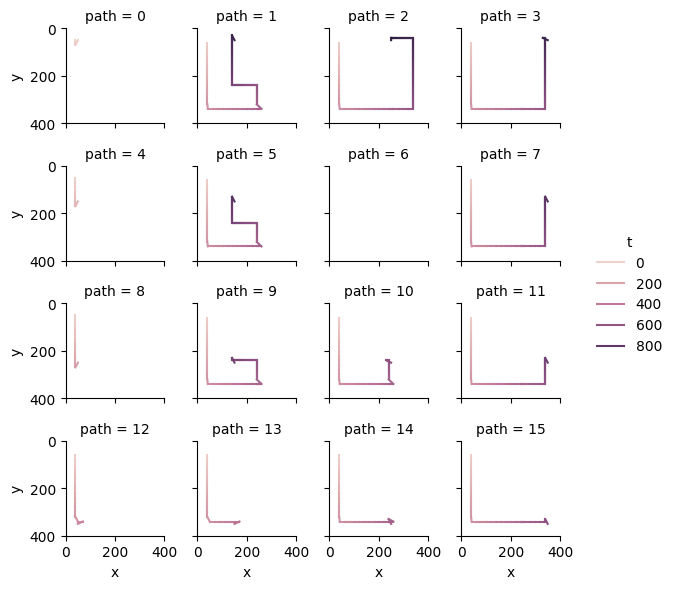

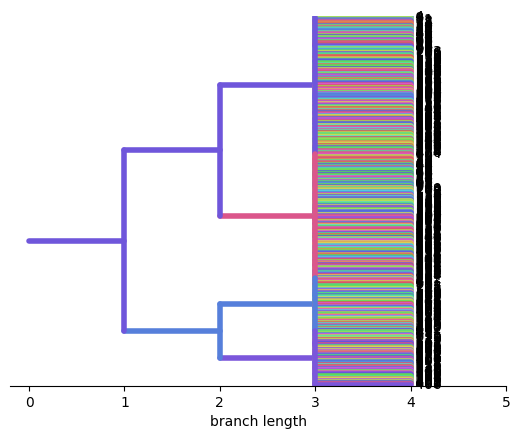

In [9]:
obvs = show_sample_observations(
    SX,
    SY,
    crea_func=np.ones,
    mirror_backtrack=True,
    mirror_backtrack_transform=mirror_backtrack_transform,
    num_frames=num_frames,
)
observations = pathsplot(
    [
        build_path(coordinate, obvs, AttributeBoxMax(20))
        for coordinate in tqdm(seed_coordinates)
    ],
    xmax=SX,
    ymax=SY,
    col_wrap=4,
)
plt.show()

show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    dstream_algo=dstream_algo,
    dstream_S=dstream_S,
    num_frames=num_frames,
)


## `crea_func=np.random.rand` `mirror_backtrack=False`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 203 colors in source)


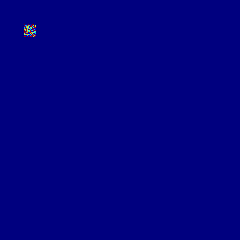

exit log_context_duration for Creating video
!!! {"Creating video": 5.180809497833252}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 210 colors in source)


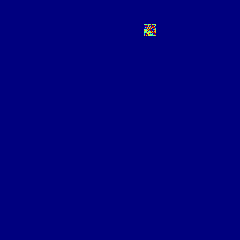

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.050801992416382}


100%|██████████| 16/16 [00:01<00:00,  9.85it/s]


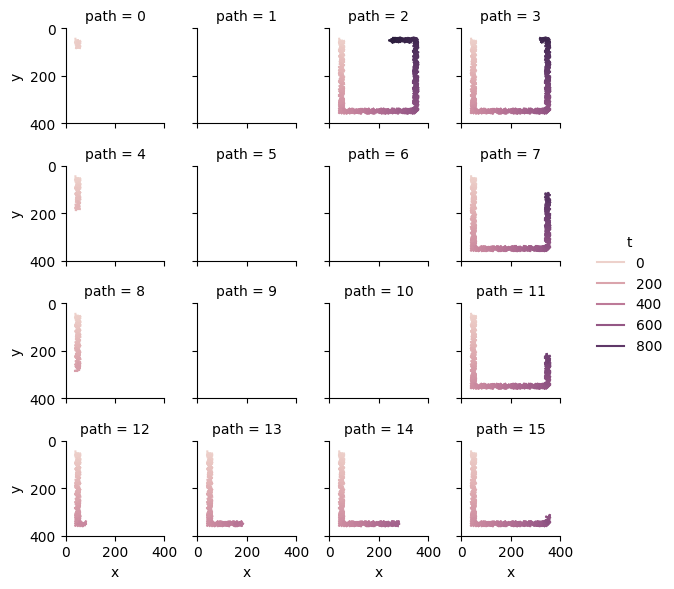

enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 208 colors in source)


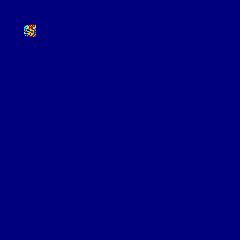

exit log_context_duration for Creating video
!!! {"Creating video": 4.9677863121032715}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 209 colors in source)


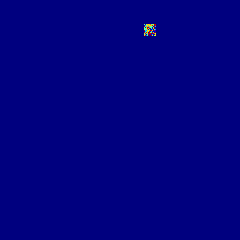

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.926807641983032}


100%|██████████| 16/16 [00:01<00:00,  9.56it/s]


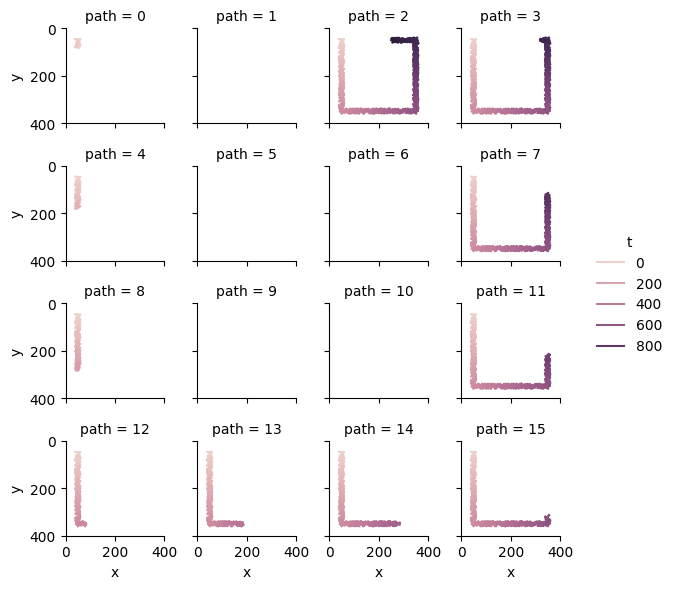

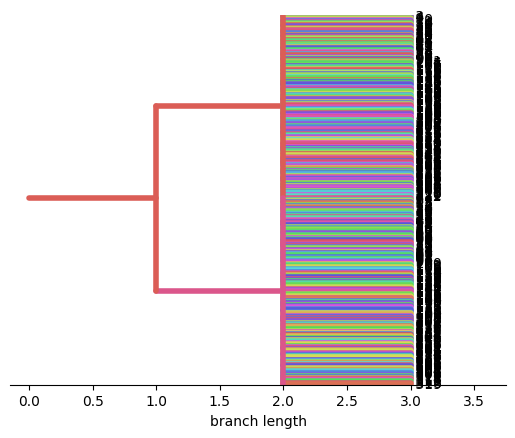

In [10]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        crea_func=lambda x: np.random.rand(*x),
        mirror_backtrack=False,
        num_frames=num_frames,
    )
    observations = pathsplot(
        [
            build_path(coordinate, obvs, AttributeBoxMax(20))
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    dstream_algo=dstream_algo,
    dstream_S=dstream_S,
    num_frames=num_frames,
)


## `crea_func=np.random.rand` `mirror_backtrack=True`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 213 colors in source)


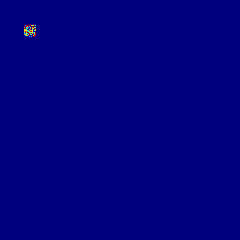

exit log_context_duration for Creating video
!!! {"Creating video": 5.317832708358765}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 214 colors in source)


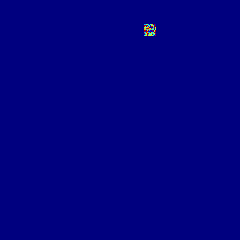

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.39298415184021}


100%|██████████| 16/16 [00:01<00:00,  9.32it/s]


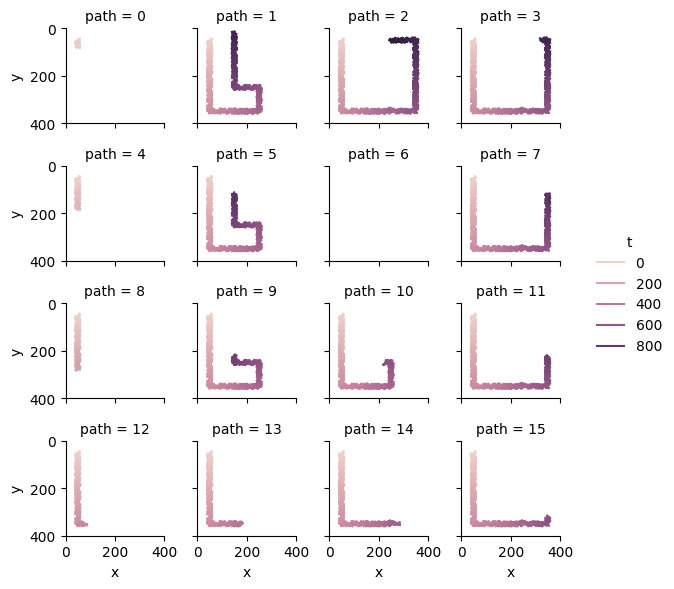

enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 208 colors in source)


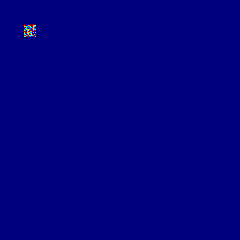

exit log_context_duration for Creating video
!!! {"Creating video": 5.386598587036133}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 209 colors in source)


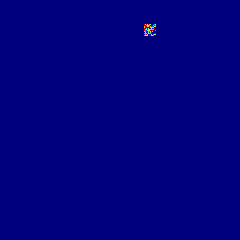

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.033029317855835}


100%|██████████| 16/16 [00:01<00:00,  9.58it/s]


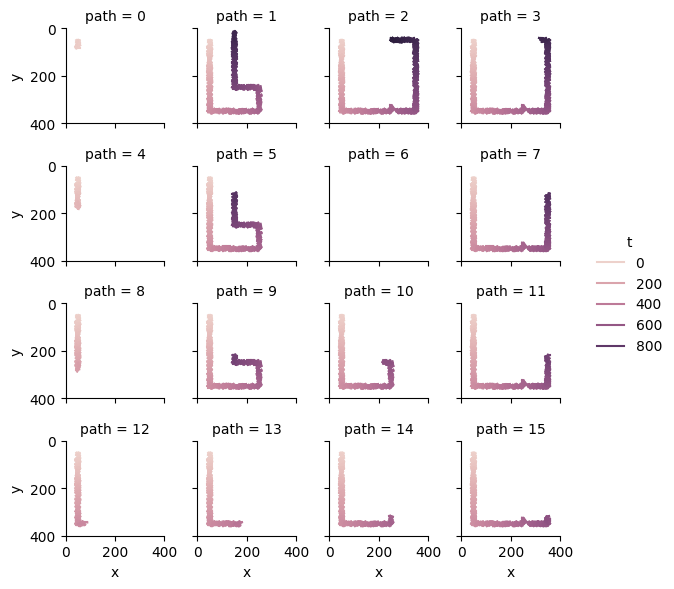

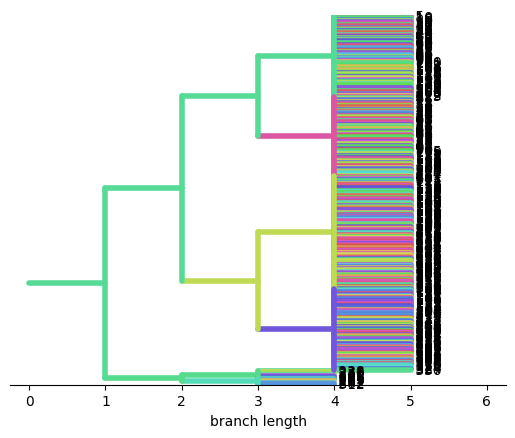

In [11]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        crea_func=lambda x: np.random.rand(*x),
        mirror_backtrack=True,
        mirror_backtrack_transform=mirror_backtrack_transform,
        num_frames=num_frames,
    )
    observations = pathsplot(
        [
            build_path(coordinate, obvs, AttributeBoxMax(20))
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    dstream_algo=dstream_algo,
    dstream_S=dstream_S,
    num_frames=num_frames,
)
